# Race Dashboard



This document describes the requirements and design decisions we will adopt for the Race Dashboard for the Sanofi Asset Efficiency challenge.  This document is intended to provide a detailed explanation of what is to be included on the dashboard, required data sources, and assumptions being made in the design.  It will also show the steps for getting the data into the necessary format.

## Scope/objective

The objective is to be able to display the documented metrics and categories as best suited on a Dashboard presentation for Sanofi staff to be able to access.


## Metrics / categories
The metrics have been mapped into sectors to mimic different sectors of a race track.  The metrics are:
 
 
 
•     Race = 8 Laps = 8 Months   
•     Lap = Monthly Progress   
<br>
<br>

•     **Sector 1 = OEE Improvement   
•     Sector 2 = OEE Variability Improvement   
•     Sector 3 = Stoppage Reduction   
•     Sector 4 = Changeover Improvement**   
• _Sector 5 = Most effective OEE application   
• Sector 6 = Best Innovation   
• Sector 7 = Most consistent OEE improvement progress   
• Sector 8 = Collaboration   
• Sector 9 = Team Spirit_

 
 


| Change log |
|:----------:|    


| Date | Initials | Comments |
|------|:---------|:---------|
| 2021-06-23 | MC | in leaderboard, replace NaN values in laptime calc with the max laptime for that lap
| 2021-06-23 | MC | use race review dates for grouping data, rather than calendar months
| 2021-06-24 |JB | missing OEE_Diff figures should default to 'OEE %' - OEE start point, not just 'OEE %' value
| 2021-06-24 |JB | for sector one, multiply sum of OEE_Diff by -1.  (was doing this in Tableau calcs but too late for lap_time calc).
|2021-06-25 | MC | in leaderboard, change prev_race_time calc to include all but last 2 cols, to handle new race cols as they arrive
|2021-06-28 | MC | correct dates in nominations spreadsheet, and merge on 1 row with a date within the review period
|2021-06-29 | MC | corrected nominations spreadsheet for Lisieux IWK - should be TR200 Packaging
|2021-06-30 | MC | populate missing OEE % values before calculating rolling_std using the OEE % column
|2021-06-30 | MC | remove start_changeover_calc merge as it's not being used any more, and was dropping rows
|2021-07-06 | MC | populate missing OEE % values with OEE from previous week for that site.
|2021-07-12 | MC | import nominations for sectors 10 and 11

In [107]:
import pandas as pd
import numpy as np
import datetime


# Viz libs
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# display options
# pd.options.display.float_format = "{:.2f}".format


## Read file and cleanse

- OEE.xlsx should contain the OEE latest data from QS by week   
- QSDashboard.xlsx has a list of plants/sites taking part, with original target OEE  
- UnplannedTechLoss.xlxs should contain the latest data from QS (my unplanned chart by line/week)   
- changeover.xlsx should contain the changeover information in QlikSense

#### Cleaning required:   
- OEE % needs converting to numeric, coerce the nulls to nan values
- I think W53-2020 data is bobbings - causes dup indexes for date 2021-01-10 and don't need 2020 data anyway...so dropping it

In [108]:
# this dir should point at where ever your sanofi Mclaren directory is syncing
# dir = "C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Race Dashboard data/"

from sys import platform
# if platform == "linux" or platform == "linux2":
    # linux    
if platform == "darwin":
    # OS X
    dir = "/Users/mark/Documents/GitHub/raceDashboard/Race Dashboard data/"
elif platform == "win32":
    # Windows...
    dir = "C:/Users/mark_/Documents/McLaren2021/Sanofi/Race Dashboard data/"
    # dir = "C:/Users/mark_/Sanofi/Sanofi x McLaren sharing - General/Race Dashboard data/"

    # dir = 'C:/Users/james.blood/Documents/McLarenSanofi/McLarenSanofi/data/'

    
# write out the files where ever you like.  As long as same file is used within Tableau.


file = (dir + 'OEE.xlsx')
df_weekly = pd.read_excel(file)
file = (dir + 'QSDashboard.xlsx')
df_dash = pd.read_excel(file)
file = (dir + 'Unplanned_tech_loss.xlsx')
df_techloss = pd.read_excel(file)
file = (dir + 'changeover.xlsx')
df_changeover = pd.read_excel(file)
df_weekly = df_weekly.loc[df_weekly['Week'].str.contains('2021')]
df_techloss = df_techloss.loc[df_techloss['Week'].str.contains('2021')]
df_weekly['OEE %'] = pd.to_numeric(df_weekly['OEE %'], errors='coerce')
df_techloss.rename(columns={'Unplanned losses - %OEE':'Unplanned_tech_loss'}, inplace=True)
df_techloss['Unplanned_tech_loss'] = pd.to_numeric(df_techloss['Unplanned_tech_loss'], errors='coerce')
df_changeover.rename(columns={'Change over losses - %OEE':'Changeover'}, inplace=True)
df_changeover['Changeover'] = pd.to_numeric(df_changeover['Changeover'], errors='coerce')
# don't use their progress figure as it's a static val
# df_dash.rename(columns={'⇗ OEE% progress':'OEE% progress'}, inplace=True)

In [109]:
df_weekly[['Line','OEE %']][df_weekly.Line.str.contains('AL5')]

,Line,OEE %
143,AL5 Packaging 1,NaN
156,AL5 Packaging 1,NaN
169,AL5 Packaging 1,0.449745
182,AL5 Packaging 1,0.642652
195,AL5 Packaging 1,0.505804
210,AL5 Packaging 1,0.443611
225,AL5 Packaging 1,0.507565
240,AL5 Packaging 1,NaN
255,AL5 Packaging 1,NaN
270,AL5 Packaging 1,0.000000


In [110]:
# we're ignoring data from before 2021-04-01
start_date = '2021-04-01'

# this is needed to prevent including additional values in the race time.
# 	Review_Date
# 0	2021-04-15
# 1	2021-05-13
# 2	2021-06-10
# 3	2021-07-08
# 4	2021-08-19
# 5	2021-09-16
# 6	2021-10-14
# 7	2021-11-18

review_date = '2021-08-19'


create a datetime from the week number

In [111]:
df_weekly['WeekOfYear'] = pd.to_numeric(df_weekly['Week'].str[1:3])
df_weekly['Year'] = pd.to_numeric(df_weekly['Week'].str[4:])
dates = df_weekly.Year*100+df_weekly.WeekOfYear
df_weekly['Date'] = pd.to_datetime(dates.astype(str) + '0', format='%Y%W%w')
# df_weekly.drop(columns=['Year','WeekOfYear'], inplace=True)
df_weekly.head()

,Week,Line,OEE %,WeekOfYear,Year,Date
11,W01-2021,C2 Packaging Line,0.168970,1,2021,2021-01-10
12,W01-2021,C9 Packaging Line,NaN,1,2021,2021-01-10
13,W01-2021,GAMMA1,0.406686,1,2021,2021-01-10
14,W01-2021,IMA C80/2,0.510044,1,2021,2021-01-10
15,W01-2021,L18 Packaging Line,0.173736,1,2021,2021-01-10


In [112]:
#merge the 2 dataframes to get the start OEE
df_weekly = df_weekly.merge(df_dash[['Plant','Line', 'OEE  Start point','OEE% Target (2022)']],on='Line')

In [113]:
df_weekly = df_weekly.merge(df_techloss[['Line', 'Week', 'Unplanned_tech_loss']],on=['Line','Week'])

In [114]:
df_weekly = df_weekly.merge(df_changeover[['Line','Week','Changeover']])

#### Start Changeover

*not sure this is needed if we are using changeover_diff, which will naturally reward increases / decreases in changeover??*

Start changeover value isn't provided, so going to calc our own start point using the average changeover for each site in 2021 up to April 2021.  This needs to be done before we drop the early 2021 rows.

This is then merged into the df_weekly dataframe as a loose join.

In [115]:
# start_changeover_calc = df_weekly[['Plant','Line','Changeover']][df_weekly['Date'] < '2021-04-30'].groupby(['Plant','Line']).mean().reset_index()
# start_changeover_calc.rename(columns={'Changeover':'start_changeover'}, inplace=True)
# df_weekly = df_weekly.merge(start_changeover_calc[['Line','start_changeover']])

#### Dates for the Asset Challenge

Start Date is going to be fixed as 2021-04-01. Remove all the rows from df_weekly before this date

Review Date will move and act as a cutoff for each Race meeting

In [116]:
df_weekly = df_weekly[df_weekly['Date'] > start_date].sort_values('Date')



### PCT_CHANGE
Using pct_change python function with periods=4, giving a 4 week (4 previous rows) rolling pct_change figure
- I believe we are doing this rolling average calculation within Tableau at the moment, so this isn't being used here

- Not sure whether this is required any more - removing for all categories (2021-06-30)

In [117]:
# df_weekly.sort_values(['Line','Date'], inplace = True)
# df_weekly['OEE_pct_chg'] = (df_weekly.groupby('Line')['OEE %']
#                                    .apply(pd.Series.pct_change, periods=4))
# df_weekly['techloss_pct_chg'] = (df_weekly.groupby('Line')['Unplanned_tech_loss']
#                                    .apply(pd.Series.pct_change, periods=4))
# df_weekly['Changeover_pct_chg'] = (df_weekly.groupby('Line')['Changeover']
#                                    .apply(pd.Series.pct_change, periods=4))
# df_weekly.head()

#### Populate missing OEE %
2021-06-07 - change of plan! Populating with min OEE value does not work when some Lines record 0% OEE.  Missing values can be just delayed data collection which sorts itself later.  So, until proper data arrives:

- Use the previous week's value (ffill) for that Line.  This will still leave NaN if they existed in the first row(s).  
- populate the remaining NaN with 'OEE  start point'
- ~~Find the weekly min/max OEE % from any site~~   
- ~~Merge those columns into df_weekly~~   
- ~~fill any NaN with the min OEE we calc'd for that week~~    


In [118]:
# df_weekly_minmax = (df_weekly.assign(Data_Value=df_weekly['OEE %'].abs())
#        .groupby(pd.Grouper(key='Date',freq='W'))['OEE %'].agg([('Min' , 'min'), ('Max', 'max')])
#        .add_prefix('Week'))
# df_weekly_minmax.reset_index(inplace=True)
# df_weekly = df_weekly.merge(df_weekly_minmax[['Date','WeekMin','WeekMax']])
# df_weekly['OEE %'].fillna(df_weekly.WeekMin, inplace=True)
# df_weekly.drop(columns=['WeekMin','WeekMax'], inplace=True)
df_weekly['OEE %'] = df_weekly.sort_values(['Line','Date']).groupby(['Line'])['OEE %'].ffill()
df_weekly['OEE %'] = df_weekly.sort_values(['Line','Date']).groupby(['Line'])['OEE %'].fillna(df_weekly['OEE  Start point'])
# df_weekly[df_weekly['OEE %'].isna()]
df_weekly[df_weekly.Line.str.contains('AL5')]

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),Unplanned_tech_loss,Changeover
363,W13-2021,AL5 Packaging 1,0.479693,13,2021,2021-04-04,Frankfurt,0.479693,0.5,NaN,NaN
364,W14-2021,AL5 Packaging 1,0.479693,14,2021,2021-04-11,Frankfurt,0.479693,0.5,NaN,NaN
365,W15-2021,AL5 Packaging 1,0.449745,15,2021,2021-04-18,Frankfurt,0.479693,0.5,0.314964,0.087039
366,W16-2021,AL5 Packaging 1,0.642652,16,2021,2021-04-25,Frankfurt,0.479693,0.5,0.135051,0.122727
367,W17-2021,AL5 Packaging 1,0.505804,17,2021,2021-05-02,Frankfurt,0.479693,0.5,0.280638,0.063261
368,W18-2021,AL5 Packaging 1,0.443611,18,2021,2021-05-09,Frankfurt,0.479693,0.5,0.302882,0.089293
369,W19-2021,AL5 Packaging 1,0.507565,19,2021,2021-05-16,Frankfurt,0.479693,0.5,0.230673,0.060573
370,W20-2021,AL5 Packaging 1,0.507565,20,2021,2021-05-23,Frankfurt,0.479693,0.5,NaN,NaN
371,W21-2021,AL5 Packaging 1,0.507565,21,2021,2021-05-30,Frankfurt,0.479693,0.5,NaN,NaN
372,W22-2021,AL5 Packaging 1,0.000000,22,2021,2021-06-06,Frankfurt,0.479693,0.5,0.000000,0.088889


## Standard Deviation
Calculate std_dev and mean on a 4 week rolling basis

Standard deviation is the square root of the variance, so no need to calculate both and have left var out

In [119]:
df_weekly['rolling_std'] = df_weekly.groupby('Line')['OEE %'].apply(lambda x : x.rolling(4,1).agg(np.std))
df_weekly.head(5)

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),Unplanned_tech_loss,Changeover,rolling_std
12,W13-2021,C2 Packaging Line,0.494406,13,2021,2021-04-04,Maisons-Alfort,0.399597,0.470,0.344827,0.047606,NaN
144,W13-2021,L18 Packaging Line,0.465923,13,2021,2021-04-04,Tours,0.377683,0.547,0.208273,0.134271,NaN
210,W13-2021,M18 Filling,0.046124,13,2021,2021-04-04,Frankfurt,0.443522,0.650,0.114818,0.789781,NaN
243,W13-2021,M21 Filling,0.599671,13,2021,2021-04-04,Frankfurt,0.599671,0.650,NaN,NaN,NaN
111,W13-2021,IMA C80/2,0.581304,13,2021,2021-04-04,SCOPPITO,0.451031,0.650,0.224561,0.070836,NaN


In [120]:
file = (dir + 'Nominations Category Scoring.xlsx')
# import cols A:J - increased to bring in 2 extra sectors of Changeover times and Number of stoppages
df_nom_sectors = pd.read_excel(file, sheet_name='Nomination scoring', usecols="A:J", parse_dates=['Date'])

In [121]:
df_nom_sectors['Date'] = pd.Series(df_nom_sectors['Date']).fillna(method='ffill')
df_nom_sectors = df_nom_sectors.fillna(0)

df_weekly = df_weekly.merge(df_nom_sectors[['Line','Plant','Date','Best Solution','Best Innovation','Improvement Iterations','Lessons and Sharing','Team Contribution and Spirit','Changeover times','Number of stoppages']],how='outer', on=['Date','Plant','Line'])
df_weekly

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),Unplanned_tech_loss,Changeover,rolling_std,Best Solution,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages
0,W13-2021,C2 Packaging Line,0.494406,13.0,2021.0,2021-04-04,Maisons-Alfort,0.399597,0.470,0.344827,0.047606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W13-2021,L18 Packaging Line,0.465923,13.0,2021.0,2021-04-04,Tours,0.377683,0.547,0.208273,0.134271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W13-2021,M18 Filling,0.046124,13.0,2021.0,2021-04-04,Frankfurt,0.443522,0.650,0.114818,0.789781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W13-2021,M21 Filling,0.599671,13.0,2021.0,2021-04-04,Frankfurt,0.599671,0.650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,W13-2021,IMA C80/2,0.581304,13.0,2021.0,2021-04-04,SCOPPITO,0.451031,0.650,0.224561,0.070836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,NaN,AL5 Packaging 1,NaN,NaN,NaN,2021-09-12,Frankfurt,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318,NaN,AL6,NaN,NaN,NaN,2021-09-12,Frankfurt,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
319,NaN,M18 Filling,NaN,NaN,NaN,2021-09-12,Frankfurt,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320,NaN,M21 Filling,NaN,NaN,NaN,2021-09-12,Frankfurt,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create review dates
create a review_date column for grouping the data later, so we only get the data we're interested in for each review

In [122]:
def thurs_of_weekbefore(year, week):
    return datetime.date.fromisocalendar(year, week-1, 4)  # (year, week before (w-1), thursday)

review_weeks = [16, 20, 24, 28, 34, 38, 42, 47]
review_dates = []

for i in review_weeks:
    if i > 0:
        review_dates.append((thurs_of_weekbefore(2021,i)))

df_review_dates = pd.DataFrame(review_dates)
df_review_dates.rename(columns={0:'Review_Date'}, inplace=True)
df_review_dates['Review_Date'] = pd.to_datetime(df_review_dates.Review_Date)

# df_review_dates.info()
df_weekly = pd.merge_asof(df_weekly.sort_values('Date'), df_review_dates, left_on='Date', right_on='Review_Date', allow_exact_matches=True, direction='forward')
df_review_dates

,Review_Date
0,2021-04-15
1,2021-05-13
2,2021-06-10
3,2021-07-08
4,2021-08-19
5,2021-09-16
6,2021-10-14
7,2021-11-18


#### We need the diff between the weekly OEE % figures, and the Weekly Changeover figures
Need something to calculate the OEE Progress and Changeover, otherwise we will have problems when we group and sum values later
- Create OEE_diff with OEE % from groupby of each Line, Week (only 1 row per week, so 'mean' will yield the same)   
- Find the diff between the rows in OEE_Diff for each Line   
- fillNA (first row for each Line) with OEE Start point - should only be needed on the first row for each Line   

repeat same logic for Changeover - there will be more NaN as start_changeover wasn't provided for all.  We populate this later

In [123]:
# this was calculating the wrong Diff - the first row of each site was looking at the previous site for all but the 1st calc
# needed to sort by Line and Date first 

# OEE_Diff = df_weekly.groupby(['Line',pd.Grouper(key='Date',freq='W')])['OEE %'].mean().reset_index()
# OEE_Diff["OEE_Diff"] = OEE_Diff["OEE %"].diff()
# df_weekly = df_weekly.merge(OEE_Diff[["Line","Date","OEE_Diff"]], on=(["Line","Date"]))

# df_weekly['OEE_Diff'].fillna(df_weekly['OEE %'] - df_weekly['OEE  Start point'], inplace=True)
# df_weekly[["Line","Date","OEE %","OEE_Diff"]].head(50).sort_values(by=['Line', 'Date'])

after merging with nominations spreadsheet we will have future dated rows that get in the way of calcs later - get rid of them using the review_date set earlier

In [124]:
df_weekly[df_weekly.Line.str.contains('AL5')]

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),Unplanned_tech_loss,Changeover,rolling_std,Best Solution,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Review_Date
6,W13-2021,AL5 Packaging 1,0.479693,13.0,2021.0,2021-04-04,Frankfurt,0.479693,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15
18,W14-2021,AL5 Packaging 1,0.479693,14.0,2021.0,2021-04-11,Frankfurt,0.479693,0.5,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15
27,W15-2021,AL5 Packaging 1,0.449745,15.0,2021.0,2021-04-18,Frankfurt,0.479693,0.5,0.314964,0.087039,0.017290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-13
40,W16-2021,AL5 Packaging 1,0.642652,16.0,2021.0,2021-04-25,Frankfurt,0.479693,0.5,0.135051,0.122727,0.087615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-13
66,W17-2021,AL5 Packaging 1,0.505804,17.0,2021.0,2021-05-02,Frankfurt,0.479693,0.5,0.280638,0.063261,0.085253,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-13
80,W18-2021,AL5 Packaging 1,0.443611,18.0,2021.0,2021-05-09,Frankfurt,0.479693,0.5,0.302882,0.089293,0.092469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-05-13
88,W19-2021,AL5 Packaging 1,0.507565,19.0,2021.0,2021-05-16,Frankfurt,0.479693,0.5,0.230673,0.060573,0.083941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-10
97,W20-2021,AL5 Packaging 1,0.507565,20.0,2021.0,2021-05-23,Frankfurt,0.479693,0.5,NaN,NaN,0.031694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-10
112,W21-2021,AL5 Packaging 1,0.507565,21.0,2021.0,2021-05-30,Frankfurt,0.479693,0.5,NaN,NaN,0.031977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-10
133,W22-2021,AL5 Packaging 1,0.000000,22.0,2021.0,2021-06-06,Frankfurt,0.479693,0.5,0.000000,0.088889,0.253782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-06-10


In [125]:
df_weekly = df_weekly[df_weekly['Review_Date'] <= review_date]

In [126]:
OEE_Diff = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','OEE %','OEE  Start point']]
OEE_Diff['OEE_Diff'] = OEE_Diff.groupby('Line')['OEE %'].diff().fillna(df_weekly['OEE %'] - df_weekly['OEE  Start point'])
df_weekly = df_weekly.merge(OEE_Diff[["Line","Date","OEE_Diff"]], on=(["Line","Date"]))
df_weekly[["Line","Date","OEE %","OEE_Diff"]].sort_values(by=['Line', 'Date'])

,Line,Date,OEE %,OEE_Diff
6,AL5 Packaging 1,2021-04-04,0.479693,0.000000
18,AL5 Packaging 1,2021-04-11,0.479693,0.000000
27,AL5 Packaging 1,2021-04-18,0.449745,-0.029948
40,AL5 Packaging 1,2021-04-25,0.642652,0.192906
66,AL5 Packaging 1,2021-05-02,0.505804,-0.136848
...,...,...,...,...
228,TR200 Packaging Line,2021-07-18,0.582614,0.085158
236,TR200 Packaging Line,2021-07-25,0.635595,0.052981
249,TR200 Packaging Line,2021-08-01,0.404064,-0.231532
276,TR200 Packaging Line,2021-08-08,0.455239,0.051175


In [127]:
# Changeover_Diff = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','Changeover','start_changeover']]
Changeover_Diff = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','Changeover']]
# Changeover_Diff['Changeover_Diff'] = Changeover_Diff.groupby('Line')['Changeover'].diff().fillna(df_weekly['start_changeover'] - df_weekly['Changeover'])
Changeover_Diff['Changeover_Diff'] = Changeover_Diff.groupby('Line')['Changeover'].diff().fillna(0)
df_weekly = df_weekly.merge(Changeover_Diff[["Line","Date","Changeover_Diff"]], on=(["Line","Date"]))

In [128]:
Changeover_Diff[Changeover_Diff.Line.str.contains('AL5')]

,Line,Date,Changeover,Changeover_Diff
6,AL5 Packaging 1,2021-04-04,NaN,0.000000
18,AL5 Packaging 1,2021-04-11,NaN,0.000000
27,AL5 Packaging 1,2021-04-18,0.087039,0.000000
40,AL5 Packaging 1,2021-04-25,0.122727,0.035688
66,AL5 Packaging 1,2021-05-02,0.063261,-0.059466
80,AL5 Packaging 1,2021-05-09,0.089293,0.026032
88,AL5 Packaging 1,2021-05-16,0.060573,-0.028721
97,AL5 Packaging 1,2021-05-23,NaN,0.000000
112,AL5 Packaging 1,2021-05-30,NaN,0.000000
133,AL5 Packaging 1,2021-06-06,0.088889,0.000000


In [129]:
# Changeover_mean = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','Changeover','start_changeover']]
Changeover_mean = df_weekly.sort_values(by=['Line', 'Date'])[['Line','Date','Changeover']]
Changeover_mean['Changeover_rolling_mean'] = Changeover_mean.groupby('Line')['Changeover'].apply(lambda x : x.rolling(4,1).mean())
df_weekly = df_weekly.merge(Changeover_mean[["Line","Date","Changeover_rolling_mean"]], on=(["Line","Date"]))

In [130]:
Changeover_mean[Changeover_mean.Line.str.contains('AL5')]

,Line,Date,Changeover,Changeover_rolling_mean
6,AL5 Packaging 1,2021-04-04,NaN,NaN
18,AL5 Packaging 1,2021-04-11,NaN,NaN
27,AL5 Packaging 1,2021-04-18,0.087039,0.087039
40,AL5 Packaging 1,2021-04-25,0.122727,0.104883
66,AL5 Packaging 1,2021-05-02,0.063261,0.091009
80,AL5 Packaging 1,2021-05-09,0.089293,0.090580
88,AL5 Packaging 1,2021-05-16,0.060573,0.083964
97,AL5 Packaging 1,2021-05-23,NaN,0.071042
112,AL5 Packaging 1,2021-05-30,NaN,0.074933
133,AL5 Packaging 1,2021-06-06,0.088889,0.074731


#### Populate missing Unplanned Tech Loss

- Create weekly min/max cols for Unplanned tech loss from any site   
- Merge those columns into df_weekly   
- fill any NaN rows with the max Unplanned_tech_loss found for that week   

**this might be flawed!!** 

In [131]:
df_weekly_minmax = (df_weekly.assign(Data_Value=df_weekly['Unplanned_tech_loss'].abs())
       .groupby(pd.Grouper(key='Date',freq='W'))['Unplanned_tech_loss'].agg([('Min' , 'min'), ('Max', 'max')])
       .add_prefix('WeekUTL'))
df_weekly_minmax.reset_index(inplace=True)
df_weekly = df_weekly.merge(df_weekly_minmax[['Date','WeekUTLMin','WeekUTLMax']])
df_weekly['Unplanned_tech_loss'].fillna(df_weekly.WeekUTLMax, inplace=True)
df_weekly.drop(columns=['WeekUTLMin','WeekUTLMax'], inplace=True)
df_weekly

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),Unplanned_tech_loss,...,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean
0,W13-2021,C2 Packaging Line,0.494406,13.0,2021.0,2021-04-04,Maisons-Alfort,0.399597,0.470,0.344827,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.094809,0.000000,0.047606
1,W13-2021,L25 Packaging Line,0.393740,13.0,2021.0,2021-04-04,Tours,0.351564,0.478,0.206618,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.042176,0.000000,0.132655
2,W13-2021,AL6,0.367897,13.0,2021.0,2021-04-04,Frankfurt,0.332657,0.485,0.342851,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.035240,0.000000,0.184958
3,W13-2021,C9 Packaging Line,0.371845,13.0,2021.0,2021-04-04,Maisons-Alfort,0.419899,0.530,0.229297,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,-0.048054,0.000000,0.081871
4,W13-2021,TR200 Packaging Line,0.596432,13.0,2021.0,2021-04-04,Lisieux,0.483505,0.650,0.163573,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.112928,0.000000,0.075189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,W32-2021,GAMMA1,0.522248,32.0,2021.0,2021-08-15,SCOPPITO,0.418683,0.650,0.673891,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-19,0.000000,0.000000,0.103794
288,W32-2021,TR200 Packaging Line,0.455239,32.0,2021.0,2021-08-15,Lisieux,0.483505,0.650,0.673891,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-19,0.000000,0.000000,0.257729
289,W32-2021,MEDISEAL PURAN,0.837276,32.0,2021.0,2021-08-15,SUZANO,0.577761,0.607,0.267683,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-19,0.171929,-0.089481,0.072864
290,W32-2021,LINE 01 - UHLMANN 1880,0.540709,32.0,2021.0,2021-08-15,SUZANO,0.430678,0.520,0.108460,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-19,0.073916,-0.117729,0.069722


#### Populate missing Changeover 

Now, this doesn't really work!  Sometimes the max value changeover for the week is 100%, and there isn't any correlation in my calc between OEE + Changeover + unplanned outage being < 100% ...

...but I don't think we're using/relying on changeover figure for sector calcs here or in tableau.  Going to remove these rows below.

In [132]:
df_weekly_minmax = (df_weekly.assign(Data_Value=df_weekly['Changeover'].abs())
       .groupby(pd.Grouper(key='Date',freq='W'))['Changeover'].agg([('Min' , 'min'), ('Max', 'max')])
       .add_prefix('WeekChangeover'))
df_weekly_minmax.reset_index(inplace=True)
df_weekly = df_weekly.merge(df_weekly_minmax[['Date','WeekChangeoverMin','WeekChangeoverMax']])
df_weekly['Changeover'].fillna(df_weekly.WeekChangeoverMax, inplace=True)
df_weekly.drop(columns=['WeekChangeoverMin','WeekChangeoverMax'], inplace=True)
df_weekly

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),Unplanned_tech_loss,...,Best Innovation,Improvement Iterations,Lessons and Sharing,Team Contribution and Spirit,Changeover times,Number of stoppages,Review_Date,OEE_Diff,Changeover_Diff,Changeover_rolling_mean
0,W13-2021,C2 Packaging Line,0.494406,13.0,2021.0,2021-04-04,Maisons-Alfort,0.399597,0.470,0.344827,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.094809,0.000000,0.047606
1,W13-2021,L25 Packaging Line,0.393740,13.0,2021.0,2021-04-04,Tours,0.351564,0.478,0.206618,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.042176,0.000000,0.132655
2,W13-2021,AL6,0.367897,13.0,2021.0,2021-04-04,Frankfurt,0.332657,0.485,0.342851,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.035240,0.000000,0.184958
3,W13-2021,C9 Packaging Line,0.371845,13.0,2021.0,2021-04-04,Maisons-Alfort,0.419899,0.530,0.229297,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,-0.048054,0.000000,0.081871
4,W13-2021,TR200 Packaging Line,0.596432,13.0,2021.0,2021-04-04,Lisieux,0.483505,0.650,0.163573,...,NaN,NaN,NaN,NaN,NaN,NaN,2021-04-15,0.112928,0.000000,0.075189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,W32-2021,GAMMA1,0.522248,32.0,2021.0,2021-08-15,SCOPPITO,0.418683,0.650,0.673891,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-19,0.000000,0.000000,0.103794
288,W32-2021,TR200 Packaging Line,0.455239,32.0,2021.0,2021-08-15,Lisieux,0.483505,0.650,0.673891,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-19,0.000000,0.000000,0.257729
289,W32-2021,MEDISEAL PURAN,0.837276,32.0,2021.0,2021-08-15,SUZANO,0.577761,0.607,0.267683,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-19,0.171929,-0.089481,0.072864
290,W32-2021,LINE 01 - UHLMANN 1880,0.540709,32.0,2021.0,2021-08-15,SUZANO,0.430678,0.520,0.108460,...,0.0,0.0,0.0,0.0,0.0,0.0,2021-08-19,0.073916,-0.117729,0.069722


#### Populate missing start_changeover (NaN)
If we've got this far and you still don't have a start_changeover, then you're a new site and can have this week's Changeover value

These rows still have NaN Changeover values

In [133]:
df_weekly[['Line','Date','Changeover']][df_weekly['Changeover'].isna()]

,Line,Date,Changeover


In [134]:
# df_weekly.start_changeover.fillna(df_weekly.Changeover, inplace=True)
df_weekly['OEE  Start point'].fillna(df_weekly['OEE %'], inplace=True)
df_weekly['OEE% Target (2022)'].fillna(0.65, inplace=True)

### Calculating Sector times


The lap time is a sum of the calculated sector scores + the pole position time from the F1 race data (eg for Paul Ricard it was 88 secs):



Sector [1-4] calculations   
**sector 1**
How much has your OEE increased / decreased?  Sum difference between each week and multiply total by -1.  This provides a negative figure to subtract from your laptime, so that larger OEE increase is rewarded with a bigger reduction in laptime

df_weekly['sector_1'] = df_weekly['OEE_Diff'].mul(-1)

OEE_Diff calculation
- Sort values by Line and Date
- Find the difference between each weekly OEE figure
- ~~Fill NaN values from missing OEE figures with the weekly OEE minus OEE Start Point for that site~~   
- any missing OEE figures will already be populated with previous week's value or the start OEE value


**Sector 2** 
How big was your rolling std deviation this period, over the previous 4 weeks std dev?  

df_weekly['sector_2'] = df_weekly['rolling_std']

rolling_std = rolling std deviation for past 4 weeks for each site


 
**Sector 3**
We want to reduce Unplanned tech loss (recorded as % of OEE) Unplanned tech loss is calculated within QlikSense but missing values sometimes.  Fill the missing values and then display the average Unplanned tech loss :

df_weekly['sector_3'] = df_weekly['Unplanned_tech_loss']


Populate missing unplanned tech loss:
- Create weekly min/max cols for Unplanned tech loss from any site
- Merge those columns into df_weekly
- fill any NaN unplanned tech loss rows with the max OEE calc'd for that week (bigger is worse)

 
**Sector 4**
We're trying to reduce changeover time (recorded as % of OEE).  
Start changeover value isn't provided, so calc our own start point for each Line using the average changeover in 2021 up to 30 April, 2021.
   
start_changeover_calc = df_weekly[['Plant','Line','Changeover']][df_weekly['Date'] < '2021-04-30'].groupby(['Plant','Line']).mean().reset_index()
start_changeover_calc.rename(columns={'Changeover':'start_changeover'}, inplace=True)
df_weekly = df_weekly.merge(start_changeover_calc[['Line','start_changeover']])



df_weekly['sector_4'] = df_weekly['Changeover_rolling_mean']

Changeover_mean = df_weekly.sort_values(by=['Line', 'Date'])[['Line', 'Date', 'Changeover', 'start_changeover']]   
Changeover_mean['Changeover_rolling_mean'] = Changeover_mean.groupby('Line')['Changeover'].apply(lambda x : x.rolling(4,1).mean())
df_weekly = df_weekly.merge(Changeover_mean[["Line","Date","Changeover_rolling_mean"]], on=(["Line","Date"]))



**Clean the sectors of NaN before summing them**   
Sometimes, when we haven't got enough information for pct_change calcs, we were getting no values coming through for the lap_time.  We should make sure there is a value in each of the sectors, otherwise there is an unfair advantage by not having data available.  Find all NaN values and replace with the mean for that column(sector)

**Sectors 5 - 9**   
Now sectors 5 - 11!!   
These scores are taken from the Nomination process.  Read in the Nomination s/s, merge any values we find with df_weekly, replace all NaN (missing) values with 0, and reduce the scores we find to 5% of their original value.  This value is then subtracted from the lap_time - so the better you do in the nominations the more your lap_time gets reduced by.

 
**lap_time**   
add up all the columns referencing 'sector'
df_weekly['lap_time'] = df_weekly.filter(regex='sector').sum(axis=1)


In [135]:
# df_weekly['sector_1'] = (df_weekly['WeekMax'] - df_weekly['OEE %'])
# df_weekly['sector_1'] = (df_weekly['OEE  Start point'] - df_weekly['OEE %'])
df_weekly['sector_1'] = df_weekly['OEE_Diff'].mul(-1)
df_weekly['sector_2'] = df_weekly['rolling_std']
df_weekly['sector_3'] = df_weekly['Unplanned_tech_loss']
# df_weekly['sector_4'] = (df_weekly['start_changeover'] - df_weekly['Changeover'])
# df_weekly['sector_4'] = (df_weekly['Changeover'] - df_weekly['start_changeover'])
df_weekly['sector_4'] = df_weekly['Changeover_rolling_mean']
# take 10% of the sector5-9 scores 
df_weekly[['sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11']] = df_weekly[['Best Solution','Best Innovation','Improvement Iterations','Lessons and Sharing','Team Contribution and Spirit','Changeover times','Number of stoppages']] * -0.05
df_weekly[['sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11']] = df_weekly[['sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11']].fillna(0)

# we'll use these in the absence of values for a sector
df_weekly[['sector_1','sector_2','sector_3','sector_4']] = df_weekly[['sector_1','sector_2','sector_3','sector_4']].fillna(df_weekly[['sector_1','sector_2','sector_3','sector_4']].mean())

#this will sum and handle the NaN
# df_weekly['lap_time'] = df_weekly[['sector_1','sector_2','sector_3','sector_4','sector_5','sector_6','sector_7','sector_8','sector_9']].sum(axis=1)
df_weekly['lap_time'] = df_weekly.filter(regex='sector').sum(axis=1)

# now add the pole['Laptime'] from fastf1 to the lap_time adjustment we've created
# just use 88 secs rather than playing with timedeltas for now
# df_weekly['lap_time'] = pole['LapTime'] + pd.to_timedelta(df_weekly['lap_time'], unit='S')
# df_weekly['lap_time'] = 88 + df_weekly['lap_time']
df_weekly.groupby(['Line', pd.Grouper(key='Date', freq='W')])['lap_time'].sum()
# print (df_weekly['sector_1_time'] , df_weekly['sector_2_time'] , df_weekly['sector_3_time'], df_weekly['sector_4_time'])

Line                  Date      
AL5 Packaging 1       2021-04-04    0.584853
                      2021-04-11    0.539876
                      2021-04-18    0.449241
                      2021-04-25    0.134643
                      2021-05-02    0.593747
                                      ...   
TR200 Packaging Line  2021-07-18    0.199319
                      2021-07-25    0.322280
                      2021-08-01    0.821283
                      2021-08-08    0.447327
                      2021-08-15    1.033233
Name: lap_time, Length: 292, dtype: float64

#### Write out df_weekly to excel

In [136]:
df_weekly.to_excel(dir + "df_weekly_with_calcs.xlsx")

#### Monthly Calcs

Repeat the process for a df_monthly spreadsheet.  We will use this for calculating the Leader board  
group df_weekly by review_date so we can get the right data for each review meeting

In [137]:
# df_monthly = df_weekly.groupby([pd.Grouper(key='Date',freq='M'),'Line'])[['start_changeover','OEE  Start point','OEE %','Unplanned_tech_loss','Changeover','rolling_std','techloss_pct_chg','Changeover_pct_chg']].mean().reset_index()
# df_monthly = df_weekly.groupby([pd.Grouper(key='Date',freq='M'),'Line']).lap_time.sum().reset_index()
df_monthly = df_weekly.groupby(['Review_Date','Line']).lap_time.sum().reset_index()
# change the name of review_date to save renaming all references to Date later
df_monthly = df_monthly.rename(columns={'Review_Date':'Date'})
df_monthly['lap_time'] = df_monthly['lap_time'] + 88
df_monthly.head()

,Date,Line,lap_time
0,2021-04-15,AL5 Packaging 1,89.124728
1,2021-04-15,AL6,89.134399
2,2021-04-15,C2 Packaging Line,88.810894
3,2021-04-15,C9 Packaging Line,88.909206
4,2021-04-15,GAMMA1,89.150116


### Leader board table

In [138]:
# filter using the end_date to stop picking up future dated nomination rows of zero I created when joining the s/s
# pivot = df_monthly[df_monthly['Date'] < end_date].pivot(index='Line', columns='Date', values='lap_time')
pivot = df_monthly.pivot(index='Line', columns='Date', values='lap_time')
pivot.reset_index(inplace=True)
# pivot creates NaN for rows with no monthly data for each race review data
# populate each NaN value with the max for that column - so they get the max laptime for that race
# we can search for cols [1:] and find all cols after Date and Line
pivot.iloc[:,1:] = pivot.iloc[:,1:].fillna(pivot.iloc[:,1:].max())

# sum all the columns to get a race_time
pivot['race_time'] = pivot.sum(axis=1)
# sum all but the last 2 cols (this lap and the race_time) to calc prev_race_time

# pivot['prev_race_time'] = pivot[pivot.columns[2]] + pivot[pivot.columns[3]]
pivot['prev_race_time'] = pivot.iloc[:,1:-2].sum(axis=1)

pivot = pivot.merge(df_dash[['Plant','Line']], on='Line')
pivot.sort_values('race_time', inplace=True)
pivot['position'] = np.arange(1,len(pivot) + 1)
pivot['gap_to_leader'] = pivot['race_time'] - pivot['race_time'].iloc[0]
pivot.sort_values('prev_race_time', inplace=True)
pivot['prev_position'] = np.arange(1,len(pivot) + 1)
pivot['Gain/Loss'] = pivot.prev_position - pivot.position
pivot.sort_values('race_time', inplace=True)
pivot['interval'] = pivot.race_time.diff()
pivot = pivot.merge(df_dash[['Line','OEE  Start point', '⇗ OEE% progress', 'OEE% Target (2022)']], on='Line')
pivot

,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,race_time,prev_race_time,Plant,position,gap_to_leader,prev_position,Gain/Loss,interval,OEE Start point,⇗ OEE% progress,OEE% Target (2022)
0,GAMMA1,89.150116,79.525767,79.076756,64.979194,91.288287,404.020120,312.731833,SCOPPITO,1,0.000000,1,0,NaN,0.418683,0.114193,0.650
1,IMA C80/2,88.906805,79.456522,82.482693,64.674113,90.648187,406.168319,315.520133,SCOPPITO,2,2.148199,2,0,2.148199,0.451031,0.196577,0.650
2,AL6,89.134399,90.323044,87.005598,75.552144,90.391626,432.406811,342.015185,Frankfurt,3,28.386691,4,1,26.238492,0.332657,0.054519,0.485
3,C9 Packaging Line,88.909206,89.747841,90.361488,72.580804,91.429954,433.029292,341.599339,Maisons-Alfort,4,29.009172,3,-1,0.622481,0.419899,-0.024311,0.530
4,AL5 Packaging 1,89.124728,89.725754,90.495004,75.207724,91.153720,435.706930,344.553211,Frankfurt,5,31.686810,5,0,2.677638,0.479693,-0.009396,0.500
5,L18 Packaging Line,88.843852,81.826704,89.407996,89.408602,89.879621,439.366775,349.487154,Tours,6,35.346654,6,0,3.659844,0.377683,0.082330,0.547
6,L25 Packaging Line,88.846328,82.508842,90.011979,89.859809,91.336055,442.563012,351.226958,Tours,7,38.542892,7,0,3.196238,0.351564,0.007600,0.478
7,M22 Filling,88.950536,85.806345,87.457670,89.496545,91.204900,442.915997,351.711097,Frankfurt,8,38.895876,8,0,0.352984,0.530068,-0.167956,0.650
8,M21 Filling,89.124728,87.742200,87.367181,89.747907,91.607800,445.589817,353.982017,Frankfurt,9,41.569696,9,0,2.673820,0.599671,-0.107171,0.650
9,C2 Packaging Line,88.810894,90.459918,90.261138,85.472942,91.278049,446.282942,355.004893,Maisons-Alfort,10,42.262822,10,0,0.693125,0.399597,-0.013017,0.470


#### write this out for tableau

In [139]:
pivot.to_csv(dir + "leaderboard.csv")
pivot.to_excel(dir + "leaderboard.xlsx")

# END OF PROCESSING - Sanity checks below

In [140]:
pivot.sort_values(pivot.columns[1], inplace=True)
pivot['apr_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['may_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['jun_position'] = np.arange(1,len(pivot) + 1)
pivot['temp_race_time'] = pivot[pivot.columns[[1,2,3,4]]].sum(axis=1)
pivot.sort_values(by='temp_race_time', inplace=True)
pivot['jly_position'] = np.arange(1,len(pivot) + 1)

In [141]:
# regex filter on column name contains Line, position or 2021
pivot.filter(regex='Line|position|2021').to_excel(dir + "positions.xlsx")
pivot.filter(regex='Line|position|2021').unstack()


Line          0                GAMMA1
              1             IMA C80/2
              3     C9 Packaging Line
              2                   AL6
              4       AL5 Packaging 1
                          ...        
jly_position  11                   11
              12                   12
              14                   13
              10                   14
              13                   15
Length: 180, dtype: object

In [142]:
# df_weekly.groupby(['Review_Date','Line']).lap_time.sum().reset_index()
sectors = df_weekly.filter(regex='Line|sector|Review_Date')

In [143]:
# sectors[sectors.columns[[2,3,4,5]]].sum(axis=1)
sectors = df_weekly.filter(regex='Line|sector|Review_Date')
sectors = sectors.iloc[:,0:6]
sectors = sectors.groupby(['Line','Review_Date']).sum().reset_index()
sectors['time'] = sectors.sum(axis=1)
sectors_pivot = sectors.pivot(index='Line', columns='Review_Date', values='time')
sectors_pivot.reset_index(inplace=True)
sectors_pivot
# sectors[sectors[sectors.columns[[2,3,4,5]]].sum(axis=1)
# sectors[sectors.Line.str.contains('AL5')]

Review_Date,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00
0,AL5 Packaging 1,1.124728,1.725754,2.495004,1.557724,3.153720
1,AL6,1.134399,2.323044,1.805598,1.902144,2.391626
2,C2 Packaging Line,0.810894,2.459918,2.261138,2.622942,3.278049
3,C9 Packaging Line,0.909206,1.747841,2.361488,2.130804,3.429954
4,GAMMA1,1.150116,1.725767,1.926756,1.979194,3.288287
5,IMA C80/2,0.906805,1.656522,1.732693,1.674113,2.648187
6,L18 Packaging Line,0.843852,1.426704,1.407996,1.408602,1.879621
7,L25 Packaging Line,0.846328,2.108842,2.011979,1.859809,3.336055
8,LINE 01 - UHLMANN 1880,NaN,1.350241,1.544296,1.547483,1.364482
9,M18 Filling,1.957018,2.596174,2.646232,2.979137,4.235100


In [144]:
# search for cols [1:] and find all cols after Date and Line
sectors_pivot.iloc[:,1:] = sectors_pivot.iloc[:,1:].fillna(sectors_pivot.iloc[:,1:].max())


In [145]:
sectors_pivot.sort_values(sectors_pivot.columns[1], inplace=True)
sectors_pivot['apr_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['may_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['jun_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot['temp_race_time'] = sectors_pivot[sectors_pivot.columns[[1,2,3,4]]].sum(axis=1)
sectors_pivot.sort_values(by='temp_race_time', inplace=True)
sectors_pivot['jly_position'] = np.arange(1,len(sectors_pivot) + 1)
sectors_pivot.drop(columns='temp_race_time', inplace=True)
sectors_pivot.style.background_gradient(cmap='Purples_r')

Review_Date,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,apr_position,may_position,jun_position,jly_position
6,L18 Packaging Line,0.843852,1.426704,1.407996,1.408602,1.879621,4,2,1,1
13,SUPPO Packaging Line,0.581932,1.604811,1.904755,1.318502,3.200651,1,1,3,2
5,IMA C80/2,0.906805,1.656522,1.732693,1.674113,2.648187,6,4,4,3
14,TR200 Packaging Line,0.706960,1.591164,1.381941,2.529634,3.303173,2,3,2,4
11,M22 Filling,0.950536,1.806345,2.057670,1.496545,3.204900,8,6,7,5
8,LINE 01 - UHLMANN 1880,1.957018,1.350241,1.544296,1.547483,1.364482,13,12,8,6
12,MEDISEAL PURAN,1.957018,1.012141,1.840824,1.948576,1.964618,15,10,6,7
4,GAMMA1,1.150116,1.725767,1.926756,1.979194,3.288287,12,8,5,8
7,L25 Packaging Line,0.846328,2.108842,2.011979,1.859809,3.336055,5,9,9,9
0,AL5 Packaging 1,1.124728,1.725754,2.495004,1.557724,3.153720,9,7,12,10


In [146]:
pivot.filter(regex='Line|position|2021').sort_values('jly_position').style.background_gradient(cmap='Purples_r')


,Line,2021-04-15 00:00:00,2021-05-13 00:00:00,2021-06-10 00:00:00,2021-07-08 00:00:00,2021-08-19 00:00:00,position,prev_position,apr_position,may_position,jun_position,jly_position
0,GAMMA1,89.150116,79.525767,79.076756,64.979194,91.288287,1,1,12,2,1,1
1,IMA C80/2,88.906805,79.456522,82.482693,64.674113,90.648187,2,2,6,1,2,2
3,C9 Packaging Line,88.909206,89.747841,90.361488,72.580804,91.429954,4,3,7,10,13,3
2,AL6,89.134399,90.323044,87.005598,75.552144,90.391626,3,4,11,15,8,4
4,AL5 Packaging 1,89.124728,89.725754,90.495004,75.207724,91.153720,5,5,9,11,14,5
5,L18 Packaging Line,88.843852,81.826704,89.407996,89.408602,89.879621,6,6,4,3,3,6
6,L25 Packaging Line,88.846328,82.508842,90.011979,89.859809,91.336055,7,7,5,4,4,7
7,M22 Filling,88.950536,85.806345,87.457670,89.496545,91.204900,8,8,8,5,5,8
8,M21 Filling,89.124728,87.742200,87.367181,89.747907,91.607800,9,9,10,7,6,9
9,C2 Packaging Line,88.810894,90.459918,90.261138,85.472942,91.278049,10,10,3,13,15,10


In [147]:
aggregations = {
    'sector_1':'sum',
    'sector_2':'mean',
    'sector_3':'mean',
    'sector_4':'mean',
    'sector_5':'sum',
    'sector_6':'sum',
    'sector_7':'sum',
    'sector_8':'sum',
    'sector_9':'sum',
    'sector_10':'sum',
    'sector_11':'sum',
    'lap_time':'sum'
}
# all_sectors = df_weekly.groupby(['Review_Date','Line'])[['sector_1','sector_2','sector_3','sector_4','sector_5','sector_6','sector_7','sector_8','sector_9','lap_time']].agg(aggregations).reset_index()
all_sectors = df_weekly.filter(regex='Review_Date|Line|sector|lap_time')
all_sectors = all_sectors.groupby(['Review_Date','Line']).agg(aggregations).reset_index()

In [148]:
all_sectors[all_sectors.Review_Date == '2021-08-19'].sort_values('sector_1').style.background_gradient(subset=['sector_1','sector_2','sector_3','sector_4'], cmap='Purples_r')\
    .format({'sector_1':'{:,.2f}'})\
    .format({'sector_2':'{:,.2f}'})\
    .format({'sector_3':'{:,.2f}'})\
    .format({'sector_4':'{:,.2f}'})

,Review_Date,Line,sector_1,sector_2,sector_3,sector_4,sector_5,sector_6,sector_7,sector_8,sector_9,sector_10,sector_11,lap_time
67,2021-08-19 00:00:00,M18 Filling,-0.40,0.24,0.24,0.29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.235100
70,2021-08-19 00:00:00,MEDISEAL PURAN,-0.29,0.08,0.22,0.08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.964618
66,2021-08-19 00:00:00,LINE 01 - UHLMANN 1880,-0.26,0.09,0.12,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.364482
60,2021-08-19 00:00:00,C2 Packaging Line,-0.21,0.07,0.46,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.278049
63,2021-08-19 00:00:00,IMA C80/2,-0.15,0.05,0.26,0.16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.648187
64,2021-08-19 00:00:00,L18 Packaging Line,-0.06,0.03,0.15,0.14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.879621
65,2021-08-19 00:00:00,L25 Packaging Line,-0.05,0.03,0.30,0.23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.336055
59,2021-08-19 00:00:00,AL6,-0.04,0.05,0.31,0.05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.391626
68,2021-08-19 00:00:00,M21 Filling,-0.04,0.23,0.16,0.21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.607800
62,2021-08-19 00:00:00,GAMMA1,-0.03,0.04,0.31,0.20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.288287


In [149]:
all_sectors['lap_time'] = all_sectors['lap_time'] + 88

Text(0.5, 1.0, 'OEE %')

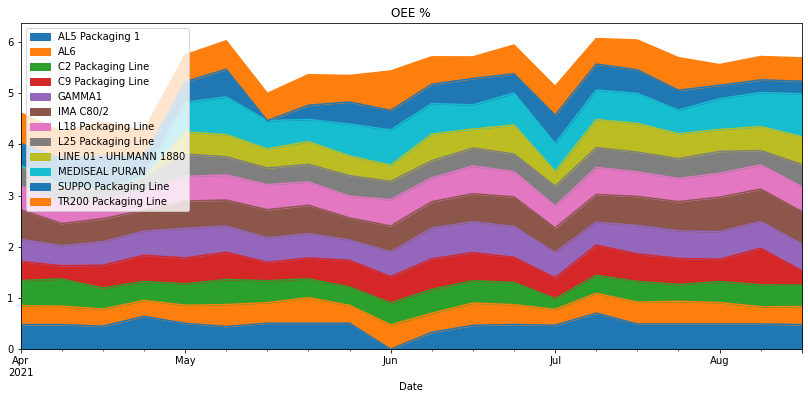

In [150]:
# for filtering in regex
SFI='M18|M21|M22'
WITHOUT_SFI='Packaging|AL6|GAMMA1|IMA|LINE|MEDISEAL'

df_weekly.pivot(index='Date',columns='Line',values='OEE %').filter(regex=WITHOUT_SFI).plot.area(figsize=(14,6))
plt.legend(loc='upper left')
plt.title('OEE %')

Text(0.5, 1.0, 'WITHOUT SFI Changeover OEE losses stacked')

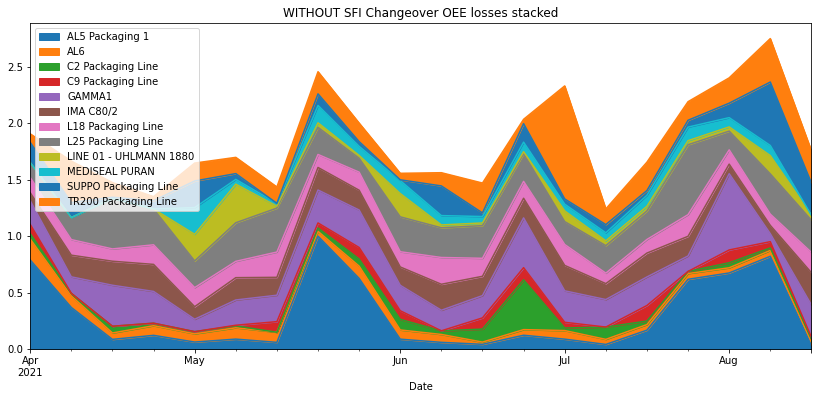

In [151]:
df_weekly.pivot(index='Date',columns='Line',values='Changeover').filter(regex=WITHOUT_SFI).plot.area(figsize=(14,6))
plt.legend(loc='upper left')
plt.title('WITHOUT SFI Changeover OEE losses stacked')

Text(0.5, 1.0, 'Unplanned Technical Outage OEE losses stacked SFI')

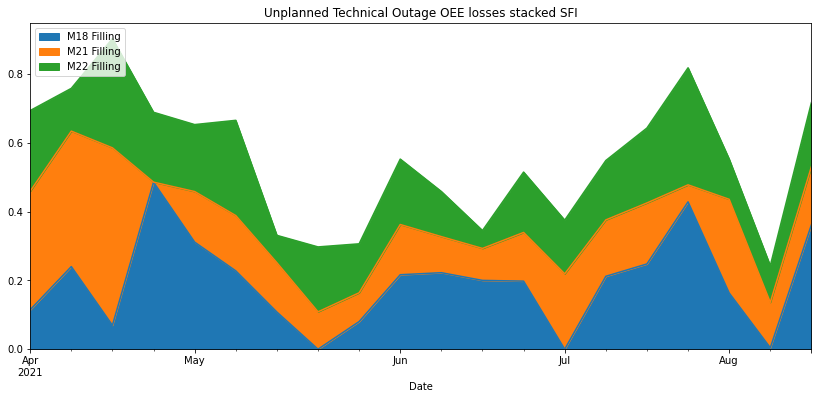

In [152]:
df_weekly.pivot(index='Date', columns='Line', values='Unplanned_tech_loss').filter(regex=SFI).plot.area(figsize=(14,6))
plt.legend(loc='upper left')
plt.title('Unplanned Technical Outage OEE losses stacked SFI')

In [153]:
df_weekly[['Line','OEE %','rolling_std','Unplanned_tech_loss','Changeover_rolling_mean','Review_Date','Date']][df_weekly.Line.str.contains('M18|M21|M22')]

,Line,OEE %,rolling_std,Unplanned_tech_loss,Changeover_rolling_mean,Review_Date,Date
7,M22 Filling,0.649336,NaN,0.234635,0.035164,2021-04-15,2021-04-04
9,M21 Filling,0.599671,NaN,0.344827,NaN,2021-04-15,2021-04-04
10,M18 Filling,0.046124,NaN,0.114818,0.789781,2021-04-15,2021-04-04
15,M18 Filling,0.463021,0.294791,0.240339,0.442593,2021-04-15,2021-04-11
21,M22 Filling,0.427316,0.156991,0.124482,0.202317,2021-04-15,2021-04-11
24,M21 Filling,0.599671,0.000000,0.394046,NaN,2021-04-15,2021-04-11
29,M21 Filling,0.599671,0.000000,0.516086,NaN,2021-05-13,2021-04-18
31,M22 Filling,0.520511,0.111485,0.317892,0.168463,2021-05-13,2021-04-18
38,M18 Filling,0.386723,0.221973,0.069673,0.425201,2021-05-13,2021-04-18
46,M22 Filling,0.703703,0.124993,0.203249,0.136297,2021-05-13,2021-04-25


In [154]:
# df_weekly['sector_1'] = df_weekly['sector_1'].mul(-1)
# df_weekly['sector_3'] = df_weekly['sector_3'].mul(-1)
# highlighted_sectors['sector_1'] = highlighted_sectors['sector_1'].mul(-1)
# highlighted_sectors['sector_3'] = highlighted_sectors['sector_3'].mul(-1)
# highlighted_sectors = df_weekly.pivot(index='Line', columns='Date', values=['sector_1','sector_2','sector_3','sector_4']).reset_index().style.highlight_max(color = 'purple', axis = 0)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: purple' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: purple' if v else '' for v in is_min]


highlighted_sectors = df_weekly[df_weekly.Review_Date == '2021-07-08']
highlighted_sectors = highlighted_sectors.pivot(index='Line', columns='Date', values=['sector_1','sector_2','sector_3','sector_4']).reset_index()
# highlighted_sectors.filter(regex='Line|_1').style.highlight_min(color = 'purple', axis=0)
# highlighted_sectors.style.highlight_min(subset=['sector_1'], color='purple')\
#     .highlight_max(subset=['sector_2'], color='purple')\
#     .highlight_min(subset=['sector_3'], color='purple')\
#     .highlight_max(subset=['sector_4'], color='purple')\
highlighted_sectors.style.background_gradient(subset=['sector_1'], cmap='Purples_r')\
    .background_gradient(subset=['sector_2'], cmap='Greens_r')\
    .background_gradient(subset=['sector_3'], cmap='Blues_r')\
    .background_gradient(subset=['sector_4'], cmap='Oranges_r')
# highlighted_sectors['sector_1'] = df_weekly.pivot(index='Line', columns='Date', values='sector_1').style.highlight_max(color = 'purple', axis = 0)
# df_weekly['sector_1'] = df_weekly['sector_1'].mul(-1)
# df_weekly['sector_3'] = df_weekly['sector_3'].mul(-1)


In [155]:
all_sectors_pivot = all_sectors.pivot(index='Line', columns='Review_Date', values=['lap_time','sector_1','sector_2','sector_3','sector_4','sector_5','sector_6','sector_7','sector_8','sector_9','sector_10','sector_11'])
all_sectors_pivot.style.background_gradient(cmap='Purples_r')

adding a weekly race_time just for the gapminder presentation

In [156]:
weekly_race_time = df_weekly.groupby(['Line','Date'])['lap_time'].sum().groupby('Line').cumsum().reset_index()
weekly_race_time.rename(columns={'lap_time' : 'race_time'}, inplace=True)
weekly_race_time['race_time'] = weekly_race_time['race_time'] + 88
df_weekly = df_weekly.merge(weekly_race_time[['Line','Date','race_time']], on=(['Line','Date']))
# df_weekly.drop(columns={'race_time'}, inplace=True)
df_weekly

,Week,Line,OEE %,WeekOfYear,Year,Date,Plant,OEE Start point,OEE% Target (2022),Unplanned_tech_loss,...,sector_4,sector_5,sector_6,sector_7,sector_8,sector_9,sector_10,sector_11,lap_time,race_time
0,W13-2021,C2 Packaging Line,0.494406,13.0,2021.0,2021-04-04,Maisons-Alfort,0.399597,0.470,0.344827,...,0.047606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391819,88.391819
1,W13-2021,L25 Packaging Line,0.393740,13.0,2021.0,2021-04-04,Tours,0.351564,0.478,0.206618,...,0.132655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.391293,88.391293
2,W13-2021,AL6,0.367897,13.0,2021.0,2021-04-04,Frankfurt,0.332657,0.485,0.342851,...,0.184958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.586765,88.586765
3,W13-2021,C9 Packaging Line,0.371845,13.0,2021.0,2021-04-04,Maisons-Alfort,0.419899,0.530,0.229297,...,0.081871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453418,88.453418
4,W13-2021,TR200 Packaging Line,0.596432,13.0,2021.0,2021-04-04,Lisieux,0.483505,0.650,0.163573,...,0.075189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.220031,88.220031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,W32-2021,GAMMA1,0.522248,32.0,2021.0,2021-08-15,SCOPPITO,0.418683,0.650,0.673891,...,0.103794,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.786865,52.020120
288,W32-2021,TR200 Packaging Line,0.455239,32.0,2021.0,2021-08-15,Lisieux,0.483505,0.650,0.673891,...,0.257729,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,1.033233,97.512873
289,W32-2021,MEDISEAL PURAN,0.837276,32.0,2021.0,2021-08-15,SUZANO,0.577761,0.607,0.267683,...,0.072864,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.323774,94.766159
290,W32-2021,LINE 01 - UHLMANN 1880,0.540709,32.0,2021.0,2021-08-15,SUZANO,0.430678,0.520,0.108460,...,0.069722,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.151630,93.806503


In [157]:
# create output for gapminder.  weekly race_time is useful for plotting and change Date format to yyyymmdd so that gapminder handles it.
df_weekly['Date'] = df_weekly['Date'].dt.strftime('%Y%m%d')
gapminder_weekly = df_weekly[['Line','Date','sector_1','sector_2','sector_3','sector_4','lap_time','race_time']]
gapminder_weekly.to_csv(dir +'gapminder_weekly.csv', index=False)




In [158]:
temp_df = df_weekly.pivot_table(index='Date', columns='Line', values='OEE %')
temp_df.columns

Index(['AL5 Packaging 1', 'AL6', 'C2 Packaging Line', 'C9 Packaging Line',
       'GAMMA1', 'IMA C80/2', 'L18 Packaging Line', 'L25 Packaging Line',
       'LINE 01 - UHLMANN 1880', 'M18 Filling', 'M21 Filling', 'M22 Filling',
       'MEDISEAL PURAN', 'SUPPO Packaging Line', 'TR200 Packaging Line'],
      dtype='object', name='Line')

<AxesSubplot:title={'center':'OEE % SFI'}, xlabel='Date'>

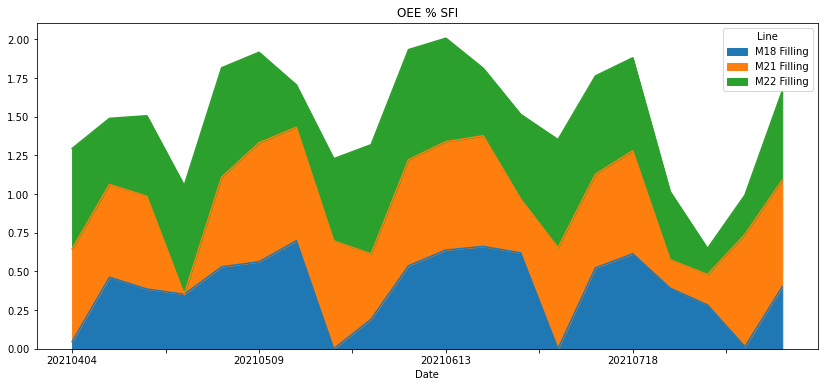

In [159]:
df_weekly.pivot_table(index='Date', columns='Line', values='OEE %').filter(regex='M18|M21|M22').plot.area(figsize=(14,6), title='OEE % SFI')

# temp_df.pivot_table(index='Date', columns='Line', values='OEE %').plot.area(figsize=(24,10), linestyle='--') 
# plt.title('SFI OEE values%') 
# plt.xlabel('Changeover')
# plt.ylabel('OEE% % Lost')

<AxesSubplot:title={'center':'OEE % Without SFI'}, xlabel='Date'>

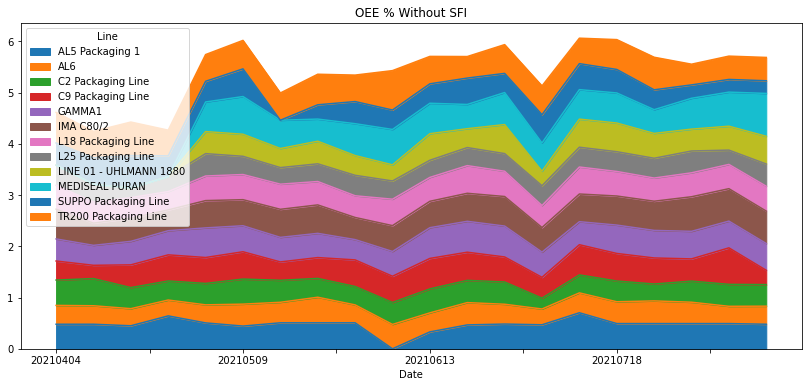

In [160]:
df_weekly.pivot_table(index='Date', columns='Line', values='OEE %').filter(regex='Packaging|AL6|GAMMA1|IMA|LINE|MEDISEAL').plot.area(figsize=(14,6), title='OEE % Without SFI')


In [161]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 292 entries, 0 to 291
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Week                          292 non-null    object        
 1   Line                          292 non-null    object        
 2   OEE %                         292 non-null    float64       
 3   WeekOfYear                    292 non-null    float64       
 4   Year                          292 non-null    float64       
 5   Date                          292 non-null    object        
 6   Plant                         292 non-null    object        
 7   OEE  Start point              292 non-null    float64       
 8   OEE% Target (2022)            292 non-null    float64       
 9   Unplanned_tech_loss           292 non-null    float64       
 10  Changeover                    292 non-null    float64       
 11  rolling_std                   27